# Importar os módulos necessários

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
        make_scorer,
        confusion_matrix, 
        cohen_kappa_score, 
        accuracy_score, 
        precision_score, 
        recall_score, 
        f1_score, 
        roc_auc_score
)
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier # decision trees for classification
from sklearn.neural_network import  MLPClassifier # neural networks for classification
from sklearn.naive_bayes import GaussianNB # naive bayes for classification
from sklearn.svm import SVC # support vector machines for classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,StackingClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier



# Definir as Métricas para Avaliação dos Modelos

In [3]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn+fp)

In [4]:
METRICS = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        #"recall": make_scorer(recall_score),
        "f1": make_scorer(f1_score),
        #"AUC": make_scorer(roc_auc_score, needs_proba=True),
        "specificity": make_scorer(specificity_score),
        #"kappa":make_scorer(cohen_kappa_score)
}

# Ler o Conjunto de Dados

In [5]:
train_data = pd.read_csv("train.csv")
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2223 non-null   float64
 1   Hardness         2620 non-null   float64
 2   Solids           2620 non-null   float64
 3   Chloramines      2620 non-null   float64
 4   Sulfate          1999 non-null   float64
 5   Conductivity     2620 non-null   float64
 6   Organic_carbon   2620 non-null   float64
 7   Trihalomethanes  2492 non-null   float64
 8   Turbidity        2620 non-null   float64
 9   Potability       2620 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 204.8 KB
None


In [6]:
test_data = pd.read_csv("test.csv")
#print(test_data.info())

# Pre-Processar Dados

In [7]:
train_data.fillna(train_data.median(), inplace=True)
test_data.fillna(train_data.median(), inplace=True)

In [8]:
"""
value_counts = train_data['Potability'].value_counts()

plt.figure(figsize=(6, 6))
colors = ["salmon", "lightgreen"]

sns.set_palette(colors)
sns.set_style("whitegrid")
plt.pie(value_counts, labels=['Not Potable', 'Potable'], autopct=lambda p: f'{int(p * sum(value_counts) / 100)}\n{p:.1f}%', startangle=90, pctdistance=0.85)
plt.title('Potability')

plt.show()
"""


'\nvalue_counts = train_data[\'Potability\'].value_counts()\n\nplt.figure(figsize=(6, 6))\ncolors = ["salmon", "lightgreen"]\n\nsns.set_palette(colors)\nsns.set_style("whitegrid")\nplt.pie(value_counts, labels=[\'Not Potable\', \'Potable\'], autopct=lambda p: f\'{int(p * sum(value_counts) / 100)}\n{p:.1f}%\', startangle=90, pctdistance=0.85)\nplt.title(\'Potability\')\n\nplt.show()\n'

In [9]:
"""
sns.scatterplot(x=train_data['ph'],y=train_data['Hardness'],color="midnightblue")
plt.show()
"""

'\nsns.scatterplot(x=train_data[\'ph\'],y=train_data[\'Hardness\'],color="midnightblue")\nplt.show()\n'

# Encontrar outliers

In [10]:
"""
fig, ax=plt.subplots(ncols=3, nrows=4, figsize=(15,25))
ax=ax.flatten()
index=0
for col, values in train_data.items():
    if index < len(ax): 
        sns.boxplot(y=col, data=train_data, ax=ax[index],color="#3874a4")
        index += 1
    else:
        break  
"""

'\nfig, ax=plt.subplots(ncols=3, nrows=4, figsize=(15,25))\nax=ax.flatten()\nindex=0\nfor col, values in train_data.items():\n    if index < len(ax): \n        sns.boxplot(y=col, data=train_data, ax=ax[index],color="#3874a4")\n        index += 1\n    else:\n        break  \n'

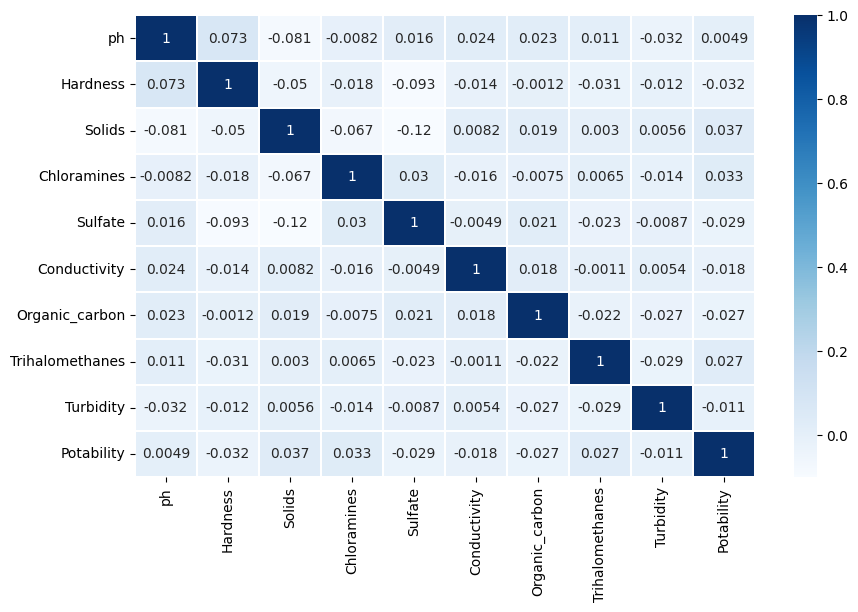

In [11]:

sns.heatmap(train_data.corr(), vmin=-0.1, vmax=1,annot=True, cmap="Blues", linewidths=0.1)
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()


In [12]:

features_with_outliers = ['Solids','Chloramines','Trihalomethanes']

#aplicar método IQR (Intervalo Interquartil)
for feature in features_with_outliers:
    Q1 = train_data[feature].quantile(0.25)
    Q3 = train_data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.7 * IQR
    upper_bound = Q3 + 1.7 * IQR
    #identificar outliers
    outliers = train_data[(train_data[feature] < lower_bound) | (train_data[feature] > upper_bound)]
    #Remover outliers do train_data DataFrame
    train_data = train_data.drop(outliers.index)  

train_data


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,10.331273,166.459779,15824.822709,6.396364,361.156178,376.102104,13.844331,52.057381,2.673441,0
1,9.616096,221.759818,12538.974026,9.089531,333.219047,441.881005,13.808375,66.668069,2.946644,1
2,4.126529,125.474884,11215.945902,5.366011,261.444798,445.241457,18.575921,86.433655,4.460201,0
3,7.039094,192.254162,21762.614146,7.259638,331.649659,397.262826,18.261213,45.981624,4.344805,1
4,9.008464,148.614002,35021.774097,5.594007,333.219047,387.399771,11.855103,49.480441,3.911015,1
...,...,...,...,...,...,...,...,...,...,...
2615,7.868147,199.035973,20434.105735,6.210994,337.916091,549.414983,16.501578,66.668069,4.315898,0
2616,8.016279,211.029304,14034.485799,9.797000,389.338796,491.079082,14.512991,35.565966,4.308223,1
2617,7.795958,239.278255,27849.142088,6.475994,356.170702,484.104784,18.692248,50.128415,4.251876,1
2618,7.054267,212.429124,7450.074375,8.727110,333.219047,396.052782,11.383954,75.219338,4.780616,0


In [13]:
# Apply SMOTE for oversampling the minority class
oversample = SMOTE(sampling_strategy='auto',random_state=1234)
X_train, y_train = oversample.fit_resample(train_data.drop("Potability", axis=1), train_data["Potability"])

In [14]:
X_test, y_test = test_data.drop("ID", axis=1), test_data["ID"]

In [15]:
"""
value_counts = y_train.value_counts()

plt.figure(figsize=(6, 6))
colors = ["salmon", "lightgreen"]

sns.set_palette(colors)
sns.set_style("whitegrid")
plt.pie(value_counts, labels=['Not Potable', 'Potable'], autopct=lambda p: f'{int(p * sum(value_counts) / 100)}\n{p:.1f}%', startangle=90, pctdistance=0.85)
plt.title('Potability')

plt.show()
"""

'\nvalue_counts = y_train.value_counts()\n\nplt.figure(figsize=(6, 6))\ncolors = ["salmon", "lightgreen"]\n\nsns.set_palette(colors)\nsns.set_style("whitegrid")\nplt.pie(value_counts, labels=[\'Not Potable\', \'Potable\'], autopct=lambda p: f\'{int(p * sum(value_counts) / 100)}\n{p:.1f}%\', startangle=90, pctdistance=0.85)\nplt.title(\'Potability\')\n\nplt.show()\n'

In [16]:
standardizer = StandardScaler()
X_train=standardizer.fit_transform(X_train)
X_test = standardizer.transform(X_test)


In [17]:
"""
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = ['ph', 'Hardness', 'Solids',	'Chloramines',	'Sulfate',	'Conductivity',	'Organic_carbon',	'Trihalomethanes',	'Turbidity']

fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(12, 25))
ax = ax.flatten()

for index, col in enumerate(X_train_df.columns):
    if index < len(ax):
        sns.boxplot(y=col, data=X_train_df, ax=ax[index], color="#3874a4")
    else:
        break
"""

'\nX_train_df = pd.DataFrame(X_train)\nX_train_df.columns = [\'ph\', \'Hardness\', \'Solids\',\t\'Chloramines\',\t\'Sulfate\',\t\'Conductivity\',\t\'Organic_carbon\',\t\'Trihalomethanes\',\t\'Turbidity\']\n\nfig, ax = plt.subplots(ncols=3, nrows=4, figsize=(12, 25))\nax = ax.flatten()\n\nfor index, col in enumerate(X_train_df.columns):\n    if index < len(ax):\n        sns.boxplot(y=col, data=X_train_df, ax=ax[index], color="#3874a4")\n    else:\n        break\n'

In [18]:
"""
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']

fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(12, 25))
ax = ax.flatten()

for index, col in enumerate(X_test_df.columns):
    if index < len(ax):
        sns.boxplot(y=col, data=X_test_df, ax=ax[index], color="#3874a4")
    else:
        break
"""        

'\nX_test_df = pd.DataFrame(X_test)\nX_test_df.columns = [\'ph\',\'Hardness\',\'Solids\',\'Chloramines\',\'Sulfate\',\'Conductivity\',\'Organic_carbon\',\'Trihalomethanes\',\'Turbidity\']\n\nfig, ax = plt.subplots(ncols=3, nrows=4, figsize=(12, 25))\nax = ax.flatten()\n\nfor index, col in enumerate(X_test_df.columns):\n    if index < len(ax):\n        sns.boxplot(y=col, data=X_test_df, ax=ax[index], color="#3874a4")\n    else:\n        break\n'

# Definir o Método de Validação Cruzada
O modelo é treinado e testado em 10 partições

In [19]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234) 

# Implementação dos Algoritmos de Machine Learning

In [20]:
"""
model = [DecisionTreeClassifier(), SVC(),
         MLPClassifier(), GaussianNB(), RandomForestClassifier(), XGBClassifier(), KNeighborsClassifier()]
results = []
for m in model:
    scores = cross_validate(m, X_train, y_train, scoring=METRICS, cv=splitter)
    dt_scores = pd.DataFrame(scores)
    model_name = m.__class__.__name__
    mean_scores = dt_scores.mean().to_dict()
    mean_scores['model'] = model_name
    results.append(mean_scores)

model_df = pd.DataFrame(results)
model_df

"""

"\nmodel = [DecisionTreeClassifier(), SVC(),\n         MLPClassifier(), GaussianNB(), RandomForestClassifier(), XGBClassifier(), KNeighborsClassifier()]\nresults = []\nfor m in model:\n    scores = cross_validate(m, X_train, y_train, scoring=METRICS, cv=splitter)\n    dt_scores = pd.DataFrame(scores)\n    model_name = m.__class__.__name__\n    mean_scores = dt_scores.mean().to_dict()\n    mean_scores['model'] = model_name\n    results.append(mean_scores)\n\nmodel_df = pd.DataFrame(results)\nmodel_df\n\n"

### Árvores de Decisão

In [21]:

dt = DecisionTreeClassifier(max_depth=18,random_state=1234)
"""
scores = cross_validate(dt, X_train, y_train, cv=splitter, scoring=METRICS)
dt_scores = pd.DataFrame(scores)
pd.DataFrame(dt_scores.mean()).T
"""


'\nscores = cross_validate(dt, X_train, y_train, cv=splitter, scoring=METRICS)\ndt_scores = pd.DataFrame(scores)\npd.DataFrame(dt_scores.mean()).T\n'

### Redes Neuronais

In [22]:


nn = MLPClassifier(hidden_layer_sizes=(150,150),max_iter=40,random_state=1234)

"""
scores_nn = cross_validate(nn, X_train, y_train, cv=splitter, scoring=METRICS)
nn_scores = pd.DataFrame(scores_nn)
pd.DataFrame(nn_scores.mean()).T
"""


'\nscores_nn = cross_validate(nn, X_train, y_train, cv=splitter, scoring=METRICS)\nnn_scores = pd.DataFrame(scores_nn)\npd.DataFrame(nn_scores.mean()).T\n'

### Naive Bayes

In [23]:

nb = GaussianNB()
"""
scores_nb = cross_validate(nb, X_train, y_train, cv=splitter, scoring=METRICS)
nb_scores = pd.DataFrame(scores_nb)
pd.DataFrame(nb_scores.mean()).T
"""

'\nscores_nb = cross_validate(nb, X_train, y_train, cv=splitter, scoring=METRICS)\nnb_scores = pd.DataFrame(scores_nb)\npd.DataFrame(nb_scores.mean()).T\n'

### Support Vector Machine

In [24]:

svm = SVC(probability=True,C=16,gamma=0.6,random_state=1234) 
"""
scores_svm = cross_validate(svm, X_train, y_train, cv=splitter, scoring=METRICS)
svm_scores = pd.DataFrame(scores_svm)
pd.DataFrame(svm_scores.mean()).T

"""

'\nscores_svm = cross_validate(svm, X_train, y_train, cv=splitter, scoring=METRICS)\nsvm_scores = pd.DataFrame(scores_svm)\npd.DataFrame(svm_scores.mean()).T\n\n'

### Random Forest Classifier

In [25]:

rf = RandomForestClassifier(n_estimators=400,max_depth=20,min_samples_leaf=1,min_samples_split=2,n_jobs=-1,random_state=1234)

"""
scores_rf = cross_validate(rf, X_train, y_train, cv=splitter, scoring=METRICS)
rf_scores = pd.DataFrame(scores_rf)
pd.DataFrame(rf_scores.mean()).T
"""


'\nscores_rf = cross_validate(rf, X_train, y_train, cv=splitter, scoring=METRICS)\nrf_scores = pd.DataFrame(scores_rf)\npd.DataFrame(rf_scores.mean()).T\n'

### XGBClassifier

In [26]:

xgb = XGBClassifier(n_estimators=500,max_depth=20,n_jobs=-1,random_state=1234)
"""
scores_xgb = cross_validate(xgb, X_train, y_train, cv=splitter, scoring=METRICS)
xgb_scores = pd.DataFrame(scores_xgb)
pd.DataFrame(xgb_scores.mean()).T
"""



'\nscores_xgb = cross_validate(xgb, X_train, y_train, cv=splitter, scoring=METRICS)\nxgb_scores = pd.DataFrame(scores_xgb)\npd.DataFrame(xgb_scores.mean()).T\n'

In [27]:
knn = KNeighborsClassifier(n_jobs=-1)
"""
scores_knn = cross_validate(knn, X_train, y_train, cv=splitter, scoring=METRICS)
knn_scores = pd.DataFrame(scores_knn)
pd.DataFrame(knn_scores.mean()).T
"""

'\nscores_knn = cross_validate(knn, X_train, y_train, cv=splitter, scoring=METRICS)\nknn_scores = pd.DataFrame(scores_knn)\npd.DataFrame(knn_scores.mean()).T\n'

In [28]:
ada=AdaBoostClassifier(estimator=rf,random_state=1234)
"""
scores_ada = cross_validate(ada, X_train, y_train, cv=splitter, scoring=METRICS)
ada_scores = pd.DataFrame(scores_ada)
pd.DataFrame(ada_scores.mean()).T
"""



'\nscores_ada = cross_validate(ada, X_train, y_train, cv=splitter, scoring=METRICS)\nada_scores = pd.DataFrame(scores_ada)\npd.DataFrame(ada_scores.mean()).T\n'

In [29]:
stacking_clf = StackingClassifier(estimators=[('rf', rf),('svm',svm),('xgb',xgb),('dt',dt),('nn',nn),('ada',ada),('knn',knn)], final_estimator=LogisticRegression(n_jobs=-1),n_jobs=-1)
"""
scores_stack = cross_validate(stacking_clf, X_train, y_train, cv=splitter, scoring=METRICS)
stack_scores = pd.DataFrame(scores_stack)
pd.DataFrame(stack_scores.mean()).T
"""


'\nscores_stack = cross_validate(stacking_clf, X_train, y_train, cv=splitter, scoring=METRICS)\nstack_scores = pd.DataFrame(scores_stack)\npd.DataFrame(stack_scores.mean()).T\n'

In [30]:
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=20,
                                                       n_estimators=400,
                                                       n_jobs=-1,
                                                       random_state=1234)),
                               ('svm',
                                SVC(C=16, gamma=0.6, probability=True,
                                    random_state=1234)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=N...
                                DecisionTreeClassifier(max_depth=18,
                                                       random_state=1234)),
                               ('nn',
                                MLPClassifier(hidden_layer_sizes=(150, 150),
                                              max_iter=40, random_state=1234)),
                               ('ada',
                                AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=20,
                                                                                    n_estimators=400,
                                                                                    n_jobs=-1,
                                                                                    random_state=1234),
                                                   random_state=1234)),
                               ('knn', KNeighborsClassifier(n_jobs=-1))],
                   final_estimator=LogisticRegression(n_jobs=-1), n_jobs=-1)

In [31]:
"""
feature_names = ["ph", "Hardness", "Solids", "Chloramines", "Sulfate",
                 "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"]

result = permutation_importance(stacking_clf,X_train,y_train)
stack_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
stack_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
"""

'\nfeature_names = ["ph", "Hardness", "Solids", "Chloramines", "Sulfate",\n                 "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"]\n\nresult = permutation_importance(stacking_clf,X_train,y_train)\nstack_importances = pd.Series(result.importances_mean, index=feature_names)\n\nfig, ax = plt.subplots()\nstack_importances.plot.bar(yerr=result.importances_std, ax=ax)\nax.set_title("Feature importances using permutation on full model")\nax.set_ylabel("Mean accuracy decrease")\nfig.tight_layout()\nplt.show()\n'

In [32]:
y_pred = stacking_clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,

In [33]:
pickle.dump(standardizer,open('scaler.pkl','wb'))
pickle.dump(stacking_clf,open('model.pkl','wb'))

In [34]:
#train_data.to_csv("train_data.csv", index=False)
#test_data.to_csv("test_data.csv",index=False)

# Save the predictions

In [35]:

# Create a DataFrame with "id" and "prediction" columns
submission_df = pd.DataFrame({"ID": test_data["ID"], "prediction": y_pred})

# Save the submission DataFrame to a CSV file
submission_df.to_csv("submission.csv", index=False)


In [45]:

original_columns = ["ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "Organic_carbon",
                    "Trihalomethanes", "Turbidity"]

X_test_df = pd.DataFrame(X_test, columns=original_columns)
X_test_df["Potability"] = y_pred
X_test_df.to_csv("X_test_final.csv", index=False)